In [ ]:
# Cell 1 - Config & Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV
from scipy import stats

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_style("whitegrid")


In [ ]:
# Cell 2 - Mount Drive (Colab) & file path
from google.colab import drive
drive.mount('/content/drive')

# Sesuaikan path file jika perlu:
DRIVE_PATH = '/content/drive/My Drive/ML/clusteringmidterm.csv'
assert os.path.exists(DRIVE_PATH), f"File tidak ditemukan: {DRIVE_PATH}"
print("File ditemukan:", DRIVE_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File ditemukan: /content/drive/My Drive/ML/clusteringmidterm.csv


In [ ]:
# Cell 3 - Load data & basic summary
def load_data(path=DRIVE_PATH):
    df = pd.read_csv(path)
    return df

df_raw = load_data()
print("Shape:", df_raw.shape)
display(df_raw.head())
display(df_raw.describe(include='all').T)
print("\nMissing values per column:")
print(df_raw.isna().sum())


Shape: (8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CUST_ID,8950,8950,C19190,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BALANCE,8950.0,NaN,NaN,NaN,1564.474828,2081.531879,0.0,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,NaN,NaN,NaN,0.877271,0.236904,0.0,0.888889,1.0,1.0,1.0
PURCHASES,8950.0,NaN,NaN,NaN,1003.204834,2136.634782,0.0,39.635,361.28,1110.13,49039.57
ONEOFF_PURCHASES,8950.0,NaN,NaN,NaN,592.437371,1659.887917,0.0,0.0,38.0,577.405,40761.25
INSTALLMENTS_PURCHASES,8950.0,NaN,NaN,NaN,411.067645,904.338115,0.0,0.0,89.0,468.6375,22500.0
CASH_ADVANCE,8950.0,NaN,NaN,NaN,978.871112,2097.163877,0.0,0.0,0.0,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,NaN,NaN,NaN,0.490351,0.401371,0.0,0.083333,0.5,0.916667,1.0
ONEOFF_PURCHASES_FREQUENCY,8950.0,NaN,NaN,NaN,0.202458,0.298336,0.0,0.0,0.083333,0.3,1.0
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,NaN,NaN,NaN,0.364437,0.397448,0.0,0.0,0.166667,0.75,1.0



Missing values per column:
CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


Robust Preprocessing Function (missing, outliers, feat eng)

In [ ]:
# Cell 4 - Preprocessing function (returns cleaned df and X for modeling)
def preprocess(df_in, impute_median_cols=['MINIMUM_PAYMENTS','CREDIT_LIMIT']):
    df = df_in.copy()
    # keep original IDs
    if 'CUST_ID' in df.columns:
        ids = df['CUST_ID'].astype(str)
    else:
        ids = pd.Series(np.arange(len(df))).astype(str)

    # Drop ID for numeric processing
    if 'CUST_ID' in df.columns:
        df = df.drop(columns=['CUST_ID'])

    # 1) Impute selected numeric with median
    med_imp = SimpleImputer(strategy='median')
    for col in impute_median_cols:
        if col in df.columns:
            df[[col]] = med_imp.fit_transform(df[[col]])

    # 2) PRC_FULL_PAYMENT: fillna 0 and clip 0..1 if present
    if 'PRC_FULL_PAYMENT' in df.columns:
        df['PRC_FULL_PAYMENT'] = df['PRC_FULL_PAYMENT'].fillna(0).clip(0,1)

    # 3) Outlier capping using IQR per numeric column
    num_cols = df.select_dtypes(include=[np.number]).columns
    Q1 = df[num_cols].quantile(0.25)
    Q3 = df[num_cols].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[num_cols] = df[num_cols].clip(lower=lower, upper=upper, axis=1)

    # 4) Feature engineering (ratios that add meaning)
    if set(['PURCHASES','CREDIT_LIMIT']).issubset(df.columns):
        df['PURCHASES_TO_LIMIT'] = df['PURCHASES'] / (df['CREDIT_LIMIT'] + 1e-9)
    if set(['CASH_ADVANCE','CREDIT_LIMIT']).issubset(df.columns):
        df['CASHADV_TO_LIMIT'] = df['CASH_ADVANCE'] / (df['CREDIT_LIMIT'] + 1e-9)
    if set(['ONEOFF_PURCHASES','PURCHASES']).issubset(df.columns):
        df['ONEOFF_FRAC'] = df['ONEOFF_PURCHASES'] / (df['PURCHASES'] + 1e-9)
    if set(['PAYMENTS','BALANCE']).issubset(df.columns):
        df['PAY_TO_BALANCE'] = df['PAYMENTS'] / (df['BALANCE'] + 1e-9)

    # Replace inf/nan => fill 0 (safe after ratios)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    return df, ids

df_clean, ids = preprocess(df_raw)
print("After preprocessing shape:", df_clean.shape)
display(df_clean.head())


After preprocessing shape: (8950, 21)


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,PURCHASES_TO_LIMIT,CASHADV_TO_LIMIT,ONEOFF_FRAC,PAY_TO_BALANCE
0,40.900749,0.818182,95.40,0.0000,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,2,1000.0,201.802084,139.509787,0.000000,12,0.095400,0.000000,0.000000,4.933946
1,3202.467416,0.909091,0.00,0.0000,0.0,2784.552848,0.000000,0.000000,0.000000,0.250000,...,0,7000.0,4103.032597,1072.340217,0.222222,12,0.000000,0.397793,0.000000,1.281210
2,2495.148862,1.000000,773.17,773.1700,0.0,0.000000,1.000000,0.750000,0.000000,0.000000,...,12,7500.0,622.066742,627.284787,0.000000,12,0.103089,0.000000,1.000000,0.249310
3,1666.670542,0.722223,1499.00,1443.5125,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,1,7500.0,0.000000,312.343947,0.000000,12,0.199867,0.027438,0.962984,0.000000
4,817.714335,1.000000,16.00,16.0000,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,1,1200.0,678.334763,244.791237,0.000000,12,0.013333,0.000000,1.000000,0.829550


In [ ]:
# Cell 5 - Transform + Scale
def transform_and_scale(df_in):
    df = df_in.copy()
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # 1) Power transform (Yeo-Johnson) to reduce skewness (handles zeros/negatives)
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    df[num_cols] = pt.fit_transform(df[num_cols])

    # 2) RobustScaler to reduce influence outliers
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(df[num_cols])
    X_df = pd.DataFrame(X_scaled, columns=num_cols, index=df.index)

    return X_df, pt, scaler

X_df, pt_model, scaler_model = transform_and_scale(df_clean)
print("Scaled feature shape:", X_df.shape)
display(X_df.head())


Scaled feature shape: (8950, 21)


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,PURCHASES_TO_LIMIT,CASHADV_TO_LIMIT,ONEOFF_FRAC,PAY_TO_BALANCE
0,-0.871146,-1.225078,-0.381842,-0.609204,0.011645,-0.000000,-0.429054,-0.435217,-0.160436,-0.000000,...,-0.437209,-0.741618,-0.716897,-0.495739,-0.000000,0.0,-0.088526,-0.000000,-0.261773,0.508688
1,0.612440,-0.895380,-1.096909,-0.609204,-0.713240,1.094605,-0.676854,-0.435217,-0.352210,1.055385,...,-0.880746,0.623235,1.254924,0.845931,1.172517,0.0,-0.571545,1.128609,-0.261773,0.010445
2,0.479651,0.000000,0.274911,0.430384,-0.713240,-0.000000,0.531990,0.895489,-0.352210,-0.000000,...,0.232022,0.676064,-0.188361,0.464686,-0.000000,0.0,-0.057404,-0.000000,0.898395,-0.437780
3,0.280962,-1.344050,0.554887,0.513435,-0.713240,0.807263,-0.549597,0.000000,-0.352210,0.540369,...,-0.606338,0.676064,-1.724392,0.000000,-0.000000,0.0,0.262956,0.167135,0.879969,-0.637854
4,-0.026280,0.000000,-0.739965,-0.129769,-0.713240,-0.000000,-0.549597,0.000000,-0.352210,-0.000000,...,-0.606338,-0.623485,-0.139310,-0.154461,-0.000000,0.0,-0.491456,-0.000000,0.898395,-0.139468


Explained variance (2 components): 0.5953


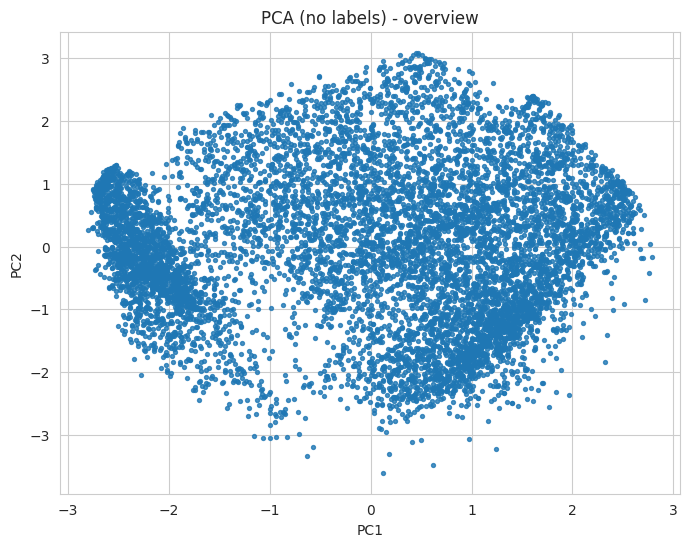

In [ ]:
# Cell 6 - PCA 2D visualization
def pca_2d_plot(X_df, labels=None, title="PCA 2D"):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    coords = pca.fit_transform(X_df)
    print("Explained variance (2 components):", pca.explained_variance_ratio_.sum().round(4))

    plt.figure(figsize=(8,6))
    if labels is None:
        plt.scatter(coords[:,0], coords[:,1], s=8, alpha=0.8)
    else:
        sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=labels, palette='tab10', s=30, legend='full')
    plt.title(title)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()
    return pca, coords

pca_model, coords = pca_2d_plot(X_df, title="PCA (no labels) - overview")


KMeans: Elbow + Silhouette + Metrics (function)

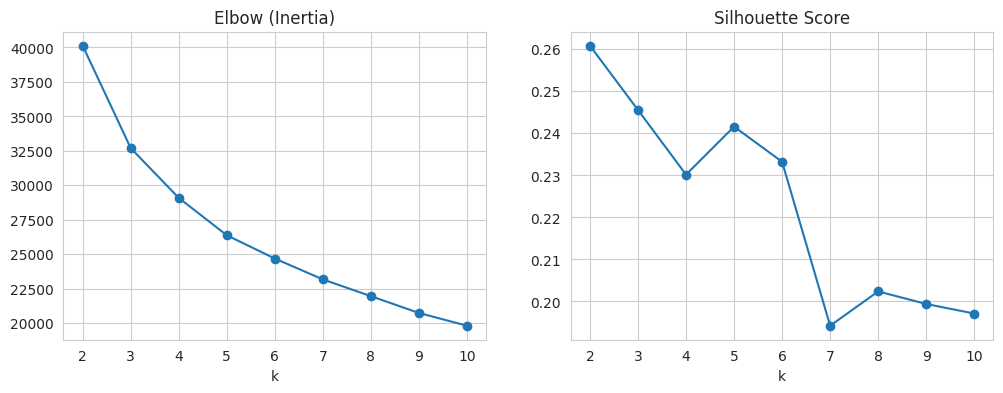

Best k by silhouette: 2
Final KMeans - silhouette: 0.2608, CH: 3375.78, DB: 1.4967
Explained variance (2 components): 0.5953


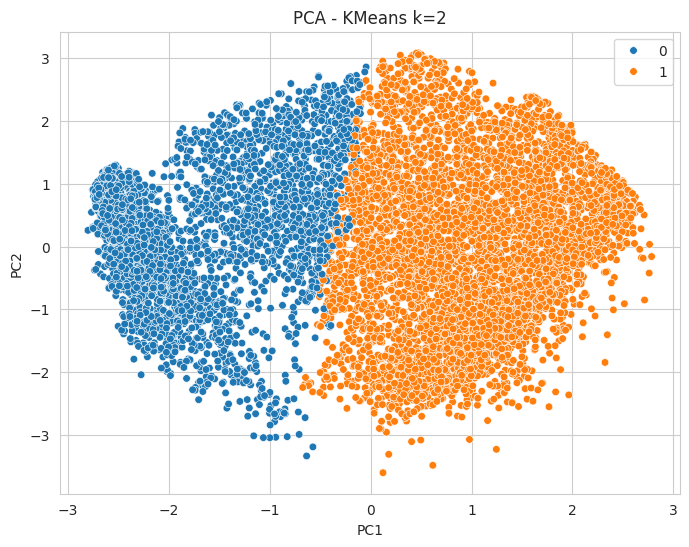

(PCA(n_components=2, random_state=42),
 array([[ 0.04403719, -2.06733615],
        [-2.14490107,  0.46196499],
        [ 0.61295341,  0.95214911],
        ...,
        [ 0.86169197, -2.22100525],
        [-1.215707  , -2.70150891],
        [ 0.41368386, -0.15112805]]))

In [ ]:
# Cell 7 - KMeans selection and fit
def kmeans_find_and_fit(X, k_min=2, k_max=10, n_init=20):
    inertias, silhouettes = [], []
    Ks = list(range(k_min, k_max+1))
    for k in Ks:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=n_init)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        silhouettes.append(silhouette_score(X, labels))

    # Plot elbow & silhouette
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(Ks, inertias, '-o'); plt.title("Elbow (Inertia)"); plt.xlabel("k")
    plt.subplot(1,2,2)
    plt.plot(Ks, silhouettes, '-o'); plt.title("Silhouette Score"); plt.xlabel("k")
    plt.show()

    best_k = Ks[int(np.argmax(silhouettes))]
    print("Best k by silhouette:", best_k)

    # Fit final KMeans with higher n_init
    km_final = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=50)
    final_labels = km_final.fit_predict(X)
    # metrics
    sil = silhouette_score(X, final_labels)
    ch = calinski_harabasz_score(X, final_labels)
    db = davies_bouldin_score(X, final_labels)
    print(f"Final KMeans - silhouette: {sil:.4f}, CH: {ch:.2f}, DB: {db:.4f}")
    return km_final, final_labels

kmeans_model, k_labels = kmeans_find_and_fit(X_df.values, k_min=2, k_max=10)
pca_2d_plot(X_df, labels=k_labels, title=f"PCA - KMeans k={kmeans_model.n_clusters}")


Agglomerative silhouette: 0.2382
Explained variance (2 components): 0.5953


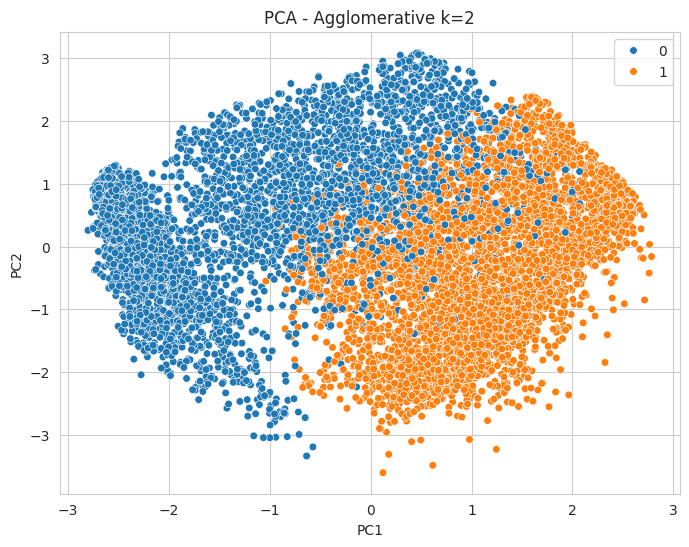

(PCA(n_components=2, random_state=42),
 array([[ 0.04403719, -2.06733615],
        [-2.14490107,  0.46196499],
        [ 0.61295341,  0.95214911],
        ...,
        [ 0.86169197, -2.22100525],
        [-1.215707  , -2.70150891],
        [ 0.41368386, -0.15112805]]))

In [ ]:
# Cell 8 - Agglomerative clustering + silhouette
def run_agglomerative(X, n_clusters):
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg.fit_predict(X)
    sil = silhouette_score(X, labels)
    print(f"Agglomerative silhouette: {sil:.4f}")
    return agg, labels

agg_model, agg_labels = run_agglomerative(X_df.values, n_clusters=kmeans_model.n_clusters)
pca_2d_plot(X_df, labels=agg_labels, title=f"PCA - Agglomerative k={kmeans_model.n_clusters}")


In [ ]:
# Cell 9 - DBSCAN exploratory (try multiple eps/min_samples)
def dbscan_explore(X, eps_list=[0.3,0.5,0.8,1.0,1.3], min_samples_list=[5,8,12]):
    best = []
    for eps in eps_list:
        for ms in min_samples_list:
            db = DBSCAN(eps=eps, min_samples=ms)
            labels = db.fit_predict(X)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters <= 1:
                score = None
            else:
                try:
                    score = silhouette_score(X, labels)
                except:
                    score = None
            best.append({'eps':eps,'min_samples':ms,'n_clusters':n_clusters,'silhouette':score})
    res = pd.DataFrame(best).sort_values(by=['n_clusters','silhouette'], ascending=[False, False])
    display(res.head(10))
    return res

db_results = dbscan_explore(X_df.values, eps_list=[0.5,0.8,1.0,1.3,1.6], min_samples_list=[5,8,12])
# pick a reasonable setting (example)
chosen_eps = float(db_results.loc[db_results['silhouette'].notnull()].iloc[0]['eps']) if not db_results[db_results['silhouette'].notnull()].empty else 1.0
chosen_ms  = int(db_results.loc[db_results['silhouette'].notnull()].iloc[0]['min_samples']) if not db_results[db_results['silhouette'].notnull()].empty else 8

db_final = DBSCAN(eps=chosen_eps, min_samples=chosen_ms)
db_labels = db_final.fit_predict(X_df.values)
print("Chosen DBSCAN eps, min_samples:", chosen_eps, chosen_ms)
n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print("Clusters found:", n_clusters_db)
if n_clusters_db > 1:
    print("DBSCAN silhouette:", silhouette_score(X_df.values, db_labels))


,eps,min_samples,n_clusters,silhouette
0,0.5,5,68,-0.266025
1,0.5,8,33,-0.230014
3,0.8,5,25,-0.132908
5,0.8,12,17,-0.067435
4,0.8,8,16,-0.041755
6,1.0,5,15,-0.280831
2,0.5,12,14,-0.188255
7,1.0,8,6,-0.194207
8,1.0,12,4,-0.217758
9,1.3,5,1,NaN


Chosen DBSCAN eps, min_samples: 0.5 5
Clusters found: 68
DBSCAN silhouette: -0.26602532161278386


Cluster Profiling (robust; numeric-only grouping)

In [ ]:
# Cell 10 - Profiling helper (returns profile frame and prints insights)
def cluster_profile(df_original, labels, label_name='KM_CLUSTER', ids_series=ids):
    dfp = df_original.copy().reset_index(drop=True)
    dfp[label_name] = labels
    # numeric-only mean+median and counts
    numeric = dfp.select_dtypes(include=[np.number]).columns.tolist()
    if label_name in numeric:
        numeric.remove(label_name)
    profile_mean = dfp.groupby(label_name)[numeric].mean()
    profile_median = dfp.groupby(label_name)[numeric].median()
    counts = dfp[label_name].value_counts().sort_index()
    print("Cluster sizes:\n", counts)
    print("\nProfile (mean):")
    display(profile_mean)
    print("\nProfile (median):")
    display(profile_median)
    # save detailed csv
    profile_mean.to_csv('cluster_profile_mean.csv')
    profile_median.to_csv('cluster_profile_median.csv')
    return profile_mean, profile_median, counts

profile_mean_km, profile_med_km, counts_km = cluster_profile(df_clean, k_labels, label_name='KM_CLUSTER', ids_series=ids)


Cluster sizes:
 KM_CLUSTER
0    3334
1    5616
Name: count, dtype: int64

Profile (mean):


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,PURCHASES_TO_LIMIT,CASHADV_TO_LIMIT,ONEOFF_FRAC,PAY_TO_BALANCE
KM_CLUSTER,,,,,,,,,,,,,,,,,,,,,
0,2155.645624,0.946762,157.504771,96.631687,52.911030,1471.913633,0.142248,0.057772,0.081584,0.270063,...,2.502699,4362.018960,1365.606829,756.626551,0.028767,12.0,0.041457,0.447374,0.244998,2.627655e+09
1,936.277208,0.922578,1081.261680,507.360274,439.589252,197.869805,0.697006,0.260169,0.532356,0.040573,...,17.038640,4453.046104,1336.087982,438.094894,0.121926,12.0,0.339213,0.054631,0.424553,4.783829e+09



Profile (median):


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,PURCHASES_TO_LIMIT,CASHADV_TO_LIMIT,ONEOFF_FRAC,PAY_TO_BALANCE
KM_CLUSTER,,,,,,,,,,,,,,,,,,,,,
0,1674.849513,1.0,0.00,0.000,0.00,1360.353362,0.000000,0.000000,0.000000,0.25,...,0.0,3000.0,868.875926,564.651525,0.0,12.0,0.00000,0.343044,0.000000,0.402672
1,337.466792,1.0,756.27,243.295,303.65,0.000000,0.833333,0.166667,0.583333,0.00,...,12.0,3000.0,844.289763,203.823355,0.0,12.0,0.22655,0.000000,0.480424,3.270579


In [ ]:
# Cell 11 - Auto-interpret clusters (simple heuristics)
def auto_interpret(profile_mean, overall_df=df_clean):
    overall_mean = overall_df.mean(numeric_only=True)
    interpretations = {}
    for c in profile_mean.index:
        row = profile_mean.loc[c]
        high = row[row > overall_mean].sort_values(ascending=False).head(5).index.tolist()
        low  = row[row < overall_mean].sort_values().head(5).index.tolist()
        interpretations[c] = {'top_high': high, 'top_low': low}
        print(f"\nCluster {c} (n={int(counts_km.get(c,0))}):")
        print("  Fitur >> lebih tinggi dari rata-rata:", high)
        print("  Fitur >> lebih rendah dari rata-rata:", low)
    return interpretations

interpretations_km = auto_interpret(profile_mean_km)



Cluster 0 (n=3334):
  Fitur >> lebih tinggi dari rata-rata: ['BALANCE', 'CASH_ADVANCE', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'CASH_ADVANCE_TRX']
  Fitur >> lebih rendah dari rata-rata: ['PRC_FULL_PAYMENT', 'PURCHASES_TO_LIMIT', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'PURCHASES_FREQUENCY']

Cluster 1 (n=5616):
  Fitur >> lebih tinggi dari rata-rata: ['PAY_TO_BALANCE', 'CREDIT_LIMIT', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES']
  Fitur >> lebih rendah dari rata-rata: ['CASH_ADVANCE_FREQUENCY', 'CASHADV_TO_LIMIT', 'CASH_ADVANCE_TRX', 'BALANCE_FREQUENCY', 'CASH_ADVANCE']


In [ ]:
# Cell 12 - Attach labels to original IDs and save results
out = pd.DataFrame({'CUST_ID': ids.values,
                    'KM_CLUSTER': k_labels,
                    'AGG_CLUSTER': agg_labels,
                    'DBSCAN_CLUSTER': db_labels})
out_path = '/content/drive/My Drive/ML/clustering_results_final.csv'
out.to_csv(out_path, index=False)
print("Saved clustering results to:", out_path)
display(out.head(10))


Saved clustering results to: /content/drive/My Drive/ML/clustering_results_final.csv


,CUST_ID,KM_CLUSTER,AGG_CLUSTER,DBSCAN_CLUSTER
0,C10001,1,1,-1
1,C10002,0,0,31
2,C10003,1,1,23
3,C10004,1,0,-1
4,C10005,0,1,7
5,C10006,1,1,0
6,C10007,1,1,1
7,C10008,1,1,0
8,C10009,1,1,-1
9,C10010,1,1,-1


In [ ]:
# Cell 13 - Auto report snippet for write-up (copy-paste to report)
def report_snippet(kmodel, k_labels, profile_mean):
    print("=== REPORT SNIPPET ===\n")
    print(f"1) Pemodelan utama: KMeans (k={kmodel.n_clusters}). Silhouette: {silhouette_score(X_df.values, k_labels):.4f}")
    print("2) Preprocessing: median imputation untuk MINIMUM_PAYMENTS & CREDIT_LIMIT; capping IQR; PowerTransformer (Yeo-Johnson); RobustScaler.")
    print("3) Feature engineering: PURCHASES_TO_LIMIT, CASHADV_TO_LIMIT, ONEOFF_FRAC, PAY_TO_BALANCE (jika ada).")
    print("4) Evaluasi tambahan: Calinski-Harabasz, Davies-Bouldin dicetak sebelumnya.")
    print("5) Profil cluster: lihat cluster_profile_mean.csv & cluster_profile_median.csv yang disimpan.")
    print("\nRekomendasi bisnis per-cluster (contoh):")
    for c in profile_mean.index:
        high = interpretations_km[c]['top_high'][:3]
        low  = interpretations_km[c]['top_low'][:3]
        print(f" - Cluster {c}: high {high}, low {low}")
    print("\nSimpan berkas hasil clustering untuk lampiran.")

report_snippet(kmeans_model, k_labels, profile_mean_km)


=== REPORT SNIPPET ===

1) Pemodelan utama: KMeans (k=2). Silhouette: 0.2608
2) Preprocessing: median imputation untuk MINIMUM_PAYMENTS & CREDIT_LIMIT; capping IQR; PowerTransformer (Yeo-Johnson); RobustScaler.
3) Feature engineering: PURCHASES_TO_LIMIT, CASHADV_TO_LIMIT, ONEOFF_FRAC, PAY_TO_BALANCE (jika ada).
4) Evaluasi tambahan: Calinski-Harabasz, Davies-Bouldin dicetak sebelumnya.
5) Profil cluster: lihat cluster_profile_mean.csv & cluster_profile_median.csv yang disimpan.

Rekomendasi bisnis per-cluster (contoh):
 - Cluster 0: high ['BALANCE', 'CASH_ADVANCE', 'PAYMENTS'], low ['PRC_FULL_PAYMENT', 'PURCHASES_TO_LIMIT', 'ONEOFF_PURCHASES_FREQUENCY']
 - Cluster 1: high ['PAY_TO_BALANCE', 'CREDIT_LIMIT', 'PURCHASES'], low ['CASH_ADVANCE_FREQUENCY', 'CASHADV_TO_LIMIT', 'CASH_ADVANCE_TRX']

Simpan berkas hasil clustering untuk lampiran.
